# Import libraries and data

In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

traindata = np.load("mnist/TRAIN-IMG.npy")
trainlabels = np.load("mnist/TRAIN-LABEL.npy")

testdata = np.load("mnist/TEST-IMG.npy")
testlabels = np.load("mnist/TEST-LABEL.npy")

print(traindata.shape,trainlabels.shape)

(60000, 28, 28) (60000,)


In [2]:
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


# Format Train and Test

In [3]:
#have to unsqueeze to get the right dimension for a cnn (1 channel image and all)
DATA=torch.tensor(traindata).to(torch.float32).unsqueeze(1).to(device)
# Make a 1hot so classification outputs the probability of each number in a different cell
LABEL=nn.functional.one_hot(
    torch.LongTensor(trainlabels), num_classes=10
).to(device).to(torch.float32)

print(DATA.shape,LABEL.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000, 10])


In [4]:
TDATA=torch.tensor(testdata).to(torch.float32).unsqueeze(1).to(device)

TLABEL=nn.functional.one_hot(
    torch.LongTensor(testlabels), num_classes=10
).to(device).to(torch.float32)

# Simple Model Structure:

```r
class Model(nn.Module):
    def __init__(self, **kwargs):
        super(Model, self).__init__()
        self.net = nn.Sequential(
                #Stuff
            )
    def forward(self, input):
        return self.net(input)
``` 

# Optimizer Setup


```r
#initialize the network
net=Model()
#training parameters
lr = 1e-4
beta1 = 0.9
beta2=0.999
#Using adam to optimize
optimizer = torch.optim.Adam(
    net.parameters(), 
    lr=lr, 
    betas=(beta1,beta2)
)
```

# Training Setup
        
Given a loss metric for the network. . .
    
```r
net.zero_grad()
loss.backward()
optimizer.step()
```

# Making A CNN

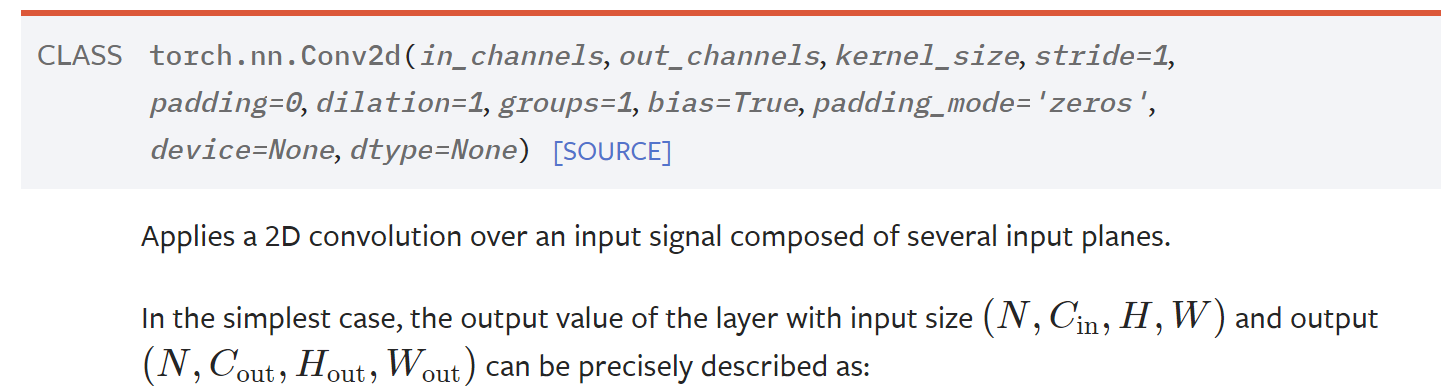

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [5]:
class CNN(nn.Module):
    def __init__(self,device):
        super(CNN, self).__init__()
        #I'm lazy so I'll just make it only work with 20x20 stuff
        self.net = nn.Sequential(
                nn.Conv2d(1,8,4),
                nn.MaxPool2d(2),
                nn.Conv2d(8,16,4),
                nn.MaxPool2d(2),
                nn.Flatten(),
                #Insize is 256, outsize is 10
                nn.Linear(256,10),
                #ReLU isn't really essential here
                nn.ReLU(True),
                #softmax to output probabilities directly
                nn.Softmax(dim=-1)
            )
        self.to(device)
    def forward(self, input):
        return self.net(input)

# Training Parameters

In [6]:
net=CNN(device)
# I print the output shape AS I make the network so I can guess and check input sizes
# Ex how big is the flattened input size after the cnn layers?
print(net(DATA[0:1]).shape)

lr = 1e-4
beta1 = 0.9
beta2=0.999
optimizer = torch.optim.Adam(
    net.parameters(), 
    lr=lr, 
    betas=(beta1,beta2)
)
LossF = nn.CrossEntropyLoss()#lambda x,y:((x-y)**2).mean()#nn.BCELoss()

torch.Size([1, 10])


# Restricting The dataset and overfitting to make show why validation may be a good idea

In [7]:
losses=[]
validation=[]

DATA=DATA[:6000]

In [8]:
epoch=500
batch=600

#set the last batch to validation
#this is a super lazy validation set 
vidx= DATA.shape[0]//batch-1

for i in range(epoch):
    #decided the last batch is validation 
    p = np.random.permutation(DATA.shape[0]//batch)
    for idx in p:
        pred = net(DATA[batch*idx:batch*(idx+1)])
        real = LABEL[batch*idx:batch*(idx+1)]
        loss = LossF(pred,real)
        net.zero_grad()
        if idx!=vidx:
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())
        else:
            validation.append(loss.cpu().item())
    if i%(epoch//100)==0:
        print("%.5f"%np.mean(losses[-p.size-1:]),end="| ")

2.32249| 2.15809| 2.05657| 1.97215| 1.91157| 1.88354| 1.86999| 1.86242| 1.85866| 1.85232| 1.84520| 1.84394| 1.83685| 1.83152| 1.82428| 1.82042| 1.81597| 1.81005| 1.80647| 1.74663| 1.72799| 1.71971| 1.71450| 1.71289| 1.70819| 1.70517| 1.70058| 1.70209| 1.69897| 1.69735| 1.69556| 1.69448| 1.69448| 1.69225| 1.69541| 1.69103| 1.68947| 1.68828| 1.68927| 1.69063| 1.68953| 1.68968| 1.68616| 1.68760| 1.68613| 1.68480| 1.68720| 1.68557| 1.68437| 1.68665| 1.68215| 1.68325| 1.68222| 1.68444| 1.68340| 1.68126| 1.68241| 1.68187| 1.67995| 1.68033| 1.67980| 1.67846| 1.67770| 1.67828| 1.67564| 1.67299| 1.67104| 1.67501| 1.67231| 1.67338| 1.67428| 1.67169| 1.66997| 1.66936| 1.67358| 1.67124| 1.67042| 1.66909| 1.66932| 1.66887| 1.66878| 1.66854| 1.67147| 1.66987| 1.66791| 1.66812| 1.66678| 1.66631| 1.66838| 1.66986| 1.66921| 1.66924| 1.66776| 1.66800| 1.66575| 1.66725| 1.66570| 1.66529| 1.66908| 1.66660| 

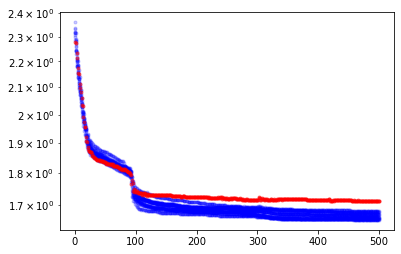

In [9]:
plt.plot(np.arange(len(losses))/vidx,losses,'.',color=(0,0,1,0.2))
plt.plot(np.arange(len(validation))+1,validation,'.',color=(1,0,0,0.5))
plt.yscale("log")
plt.show()

In [10]:
net=CNN(device)
optimizer = torch.optim.Adam(
    net.parameters(), 
    lr=lr, 
    betas=(beta1,beta2)
)
DATA=torch.tensor(traindata).to(torch.float32).unsqueeze(1).to(device)
losses=[]
validation=[]

In [11]:
epoch=100
batch=6000

vidx= DATA.shape[0]//batch-1

for i in range(epoch):
    #decided the last batch is validation 
    p = np.random.permutation(DATA.shape[0]//batch)
    for idx in p:
        pred = net(DATA[batch*idx:batch*(idx+1)])
        real = LABEL[batch*idx:batch*(idx+1)]
        loss = LossF(pred,real)
        net.zero_grad()
        if idx!=vidx:
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())
        else:
            validation.append(loss.cpu().item())
    if i%(epoch//100)==0:
        print("%.5f"%np.mean(losses[-p.size-1:]),end="| ")

2.31347| 2.28970| 2.27614| 2.25148| 2.20663| 2.18047| 2.15989| 2.13538| 2.11055| 2.08633| 2.06621| 2.03708| 2.00988| 1.98404| 1.96189| 1.94365| 1.93064| 1.91727| 1.90804| 1.89991| 1.89122| 1.88626| 1.88148| 1.87673| 1.87216| 1.86857| 1.86576| 1.86309| 1.85992| 1.85662| 1.85410| 1.85462| 1.85214| 1.84790| 1.84670| 1.84601| 1.84321| 1.84261| 1.84242| 1.84031| 1.83800| 1.83701| 1.83593| 1.83609| 1.83456| 1.83318| 1.83282| 1.83251| 1.83314| 1.83061| 1.83126| 1.82902| 1.82937| 1.82775| 1.82670| 1.82675| 1.82716| 1.82551| 1.82517| 1.82415| 1.82482| 1.82332| 1.82188| 1.82104| 1.82171| 1.82023| 1.82089| 1.82138| 1.81933| 1.81983| 1.81938| 1.81803| 1.81867| 1.81802| 1.81872| 1.81722| 1.81717| 1.81719| 1.81617| 1.81547| 1.81558| 1.81446| 1.81412| 1.81478| 1.81451| 1.81368| 1.81320| 1.81344| 1.81318| 1.81403| 1.81290| 1.81328| 1.81284| 1.81073| 1.81151| 1.81066| 1.81021| 1.81088| 1.81010| 1.81005| 

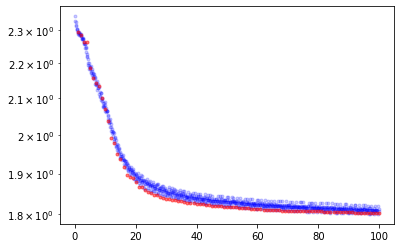

In [13]:
plt.plot(np.arange(len(losses))/vidx,losses,'.',color=(0,0,1,0.2))
plt.plot(np.arange(len(validation))+1,validation,'.',color=(1,0,0,0.5))
plt.yscale("log")
plt.show()